# Import libraries

In [1]:
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler

# Load data

In [2]:
card_df = pd.read_csv("credit-card-data.csv")
card_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
total_rows = len(card_df)
card_df.shape

(8950, 18)

# Missing Value Analysis

In [4]:
missing_val = pd.DataFrame(card_df.isnull().sum(), columns = ['Count'])
missing_val['Percentage'] = (missing_val.loc[:,'Count']*100)/len(card_df)

In [5]:
missing_val

,Count,Percentage
CUST_ID,0,0.000000
BALANCE,0,0.000000
BALANCE_FREQUENCY,0,0.000000
PURCHASES,0,0.000000
ONEOFF_PURCHASES,0,0.000000
INSTALLMENTS_PURCHASES,0,0.000000
CASH_ADVANCE,0,0.000000
PURCHASES_FREQUENCY,0,0.000000
ONEOFF_PURCHASES_FREQUENCY,0,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,0,0.000000


### Remove Missing values

In [6]:
# card_df.drop((card_df[card_df['CREDIT_LIMIT'].isnull() | card_df['MINIMUM_PAYMENTS'].isnull()]).index, inplace=True)
card_df.dropna(inplace=True)
print(f"DataLoss After removing missing values : {total_rows-len(card_df)}")

DataLoss After removing missing values : 314


In [7]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8636 non-null object
BALANCE                             8636 non-null float64
BALANCE_FREQUENCY                   8636 non-null float64
PURCHASES                           8636 non-null float64
ONEOFF_PURCHASES                    8636 non-null float64
INSTALLMENTS_PURCHASES              8636 non-null float64
CASH_ADVANCE                        8636 non-null float64
PURCHASES_FREQUENCY                 8636 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8636 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8636 non-null float64
CASH_ADVANCE_FREQUENCY              8636 non-null float64
CASH_ADVANCE_TRX                    8636 non-null int64
PURCHASES_TRX                       8636 non-null int64
CREDIT_LIMIT                        8636 non-null float64
PAYMENTS                            8636 non-null float64
MINIMUM_PAYMENTS            

Data where purchases are zero but they have pruchase transactions

In [8]:
card_df[(card_df['PURCHASES']==0) & (card_df['PURCHASES_TRX']!=0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4682,C14810,1089.795044,1.000000,0.0,0.0,20.0,38.249993,0.0,0.0,0.166667,0.083333,1,1,1200.0,284.731156,331.103830,0.000000,12
5727,C15887,1084.649802,1.000000,0.0,0.0,0.0,708.865975,0.0,0.0,0.000000,0.181818,10,1,1500.0,973.731202,252.062796,0.000000,11
8327,C18548,17.699123,0.454545,0.0,0.0,0.0,29.421611,0.0,0.0,0.000000,0.083333,1,2,2000.0,178.288304,82.738431,0.333333,12


Data where pruchase transactions are zero but they have purchases

In [9]:
card_df[(card_df['PURCHASES']!=0) & (card_df['PURCHASES_TRX']==0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1458,C11506,4.382924,0.272727,130.24,0.00,152.24,0.0,0.083333,0.000000,0.083333,0.0,0,0,14000.0,28988.973880,1092.184812,0.500000,12
3590,C13691,1.869435,0.454545,0.24,0.24,0.00,0.0,0.083333,0.083333,0.000000,0.0,0,0,3000.0,150.381107,53.294711,0.000000,12
4497,C14622,72.425884,1.000000,655.68,0.00,655.68,0.0,1.000000,0.000000,1.000000,0.0,0,0,1000.0,718.537117,162.732686,0.333333,12


In [10]:
card_df[((card_df['PURCHASES']==0) & (card_df['PURCHASES_TRX']!=0)) | ((card_df['PURCHASES']!=0) & (card_df['PURCHASES_TRX']==0))]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1458,C11506,4.382924,0.272727,130.24,0.00,152.24,0.000000,0.083333,0.000000,0.083333,0.000000,0,0,14000.0,28988.973880,1092.184812,0.500000,12
3590,C13691,1.869435,0.454545,0.24,0.24,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,0,3000.0,150.381107,53.294711,0.000000,12
4497,C14622,72.425884,1.000000,655.68,0.00,655.68,0.000000,1.000000,0.000000,1.000000,0.000000,0,0,1000.0,718.537117,162.732686,0.333333,12
4682,C14810,1089.795044,1.000000,0.00,0.00,20.00,38.249993,0.000000,0.000000,0.166667,0.083333,1,1,1200.0,284.731156,331.103830,0.000000,12
5727,C15887,1084.649802,1.000000,0.00,0.00,0.00,708.865975,0.000000,0.000000,0.000000,0.181818,10,1,1500.0,973.731202,252.062796,0.000000,11
8327,C18548,17.699123,0.454545,0.00,0.00,0.00,29.421611,0.000000,0.000000,0.000000,0.083333,1,2,2000.0,178.288304,82.738431,0.333333,12


#### Remove above data as it seems to be a false data

In [11]:
print("Rows before delete : ",len(card_df))
card_df.drop(card_df[((card_df['PURCHASES']==0) & (card_df['PURCHASES_TRX']!=0)) | ((card_df['PURCHASES']!=0) & (card_df['PURCHASES_TRX']==0))].index, inplace=True)
print("Rows after delete : ",len(card_df))

Rows before delete :  8636
Rows after delete :  8630


Data where cash advance is zero but they have cash advance transactions,
Data where cash advance transactions is zero but they have cash advance

In [12]:
card_df[((card_df['CASH_ADVANCE']==0) & (card_df['CASH_ADVANCE_TRX']!=0)) | ((card_df['CASH_ADVANCE']!=0) & (card_df['CASH_ADVANCE_TRX']==0))]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


# 1. Deriving key performance indicators(KPI)

- 1.1 - monthly average purchase
- 1.2 - monthly cash advance amount
- 1.3 - purchases by type (one-off, instalments)
- 1.4 - average amount per purchase
- 1.5 - cash advance transaction
- 1.6 - limit usage (balance to credit limit ratio)
- 1.7 - payments to minimum payments ratio 


In [13]:
# TENURE Number of months as a customer
card_df_KPI = pd.DataFrame(card_df['CUST_ID'])
card_df.TENURE.unique()

array([12,  8, 11,  9, 10,  6,  7], dtype=int64)

### 1.1 - monthly average purchase

In [14]:
# PURCHASES Total purchase amount spent during last 12 months
card_df_KPI['monthly_avg_purchase'] = card_df.PURCHASES / card_df.TENURE
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase
0,C10001,7.950000
1,C10002,0.000000
2,C10003,64.430833
4,C10005,1.333333
5,C10006,111.106667


### 1.2 - monthly cash advance amount

In [15]:
card_df_KPI['monthly_cash_advance'] = card_df.CASH_ADVANCE / card_df.TENURE
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance
0,C10001,7.950000,0.000000
1,C10002,0.000000,536.912124
2,C10003,64.430833,0.000000
4,C10005,1.333333,0.000000
5,C10006,111.106667,0.000000


### 1.3 - monthly purchases by type (one-off, instalments)

In [16]:
card_df_KPI['monthly_oneoff_purchase'] = card_df.ONEOFF_PURCHASES / card_df.TENURE
card_df_KPI['monthly_installment_purchase'] = card_df.INSTALLMENTS_PURCHASES / card_df.TENURE
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase
0,C10001,7.950000,0.000000,0.000000,7.950000
1,C10002,0.000000,536.912124,0.000000,0.000000
2,C10003,64.430833,0.000000,64.430833,0.000000
4,C10005,1.333333,0.000000,1.333333,0.000000
5,C10006,111.106667,0.000000,0.000000,111.106667


### 1.4 - average amount per purchase

In [17]:
card_df_KPI['average_amount_per_purchase'] = card_df.PURCHASES/card_df.PURCHASES_TRX
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase,average_amount_per_purchase
0,C10001,7.950000,0.000000,0.000000,7.950000,47.700000
1,C10002,0.000000,536.912124,0.000000,0.000000,NaN
2,C10003,64.430833,0.000000,64.430833,0.000000,64.430833
4,C10005,1.333333,0.000000,1.333333,0.000000,16.000000
5,C10006,111.106667,0.000000,0.000000,111.106667,166.660000


Fill nan with 0

In [18]:
card_df_KPI['average_amount_per_purchase'] = card_df_KPI['average_amount_per_purchase'].fillna(0)
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase,average_amount_per_purchase
0,C10001,7.950000,0.000000,0.000000,7.950000,47.700000
1,C10002,0.000000,536.912124,0.000000,0.000000,0.000000
2,C10003,64.430833,0.000000,64.430833,0.000000,64.430833
4,C10005,1.333333,0.000000,1.333333,0.000000,16.000000
5,C10006,111.106667,0.000000,0.000000,111.106667,166.660000


### 1.5 - average cash advance transaction

In [19]:
card_df_KPI['average_amount_per_cash_advance'] = card_df.CASH_ADVANCE/card_df.CASH_ADVANCE_TRX
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase,average_amount_per_purchase,average_amount_per_cash_advance
0,C10001,7.950000,0.000000,0.000000,7.950000,47.700000,NaN
1,C10002,0.000000,536.912124,0.000000,0.000000,0.000000,1610.736371
2,C10003,64.430833,0.000000,64.430833,0.000000,64.430833,NaN
4,C10005,1.333333,0.000000,1.333333,0.000000,16.000000,NaN
5,C10006,111.106667,0.000000,0.000000,111.106667,166.660000,NaN


Fill NaN with 0

In [20]:
card_df_KPI['average_amount_per_cash_advance'] = card_df_KPI['average_amount_per_cash_advance'].fillna(0)
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase,average_amount_per_purchase,average_amount_per_cash_advance
0,C10001,7.950000,0.000000,0.000000,7.950000,47.700000,0.000000
1,C10002,0.000000,536.912124,0.000000,0.000000,0.000000,1610.736371
2,C10003,64.430833,0.000000,64.430833,0.000000,64.430833,0.000000
4,C10005,1.333333,0.000000,1.333333,0.000000,16.000000,0.000000
5,C10006,111.106667,0.000000,0.000000,111.106667,166.660000,0.000000


### 1.6 - limit usage (balance to credit limit ratio)

In [21]:
card_df_KPI['b2c_lr'] = card_df.BALANCE/ card_df.CREDIT_LIMIT * 100
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase,average_amount_per_purchase,average_amount_per_cash_advance,b2c_lr
0,C10001,7.950000,0.000000,0.000000,7.950000,47.700000,0.000000,4.090075
1,C10002,0.000000,536.912124,0.000000,0.000000,0.000000,1610.736371,45.749535
2,C10003,64.430833,0.000000,64.430833,0.000000,64.430833,0.000000,33.268651
4,C10005,1.333333,0.000000,1.333333,0.000000,16.000000,0.000000,68.142861
5,C10006,111.106667,0.000000,0.000000,111.106667,166.660000,0.000000,100.546042


### 1.7 - payments to minimum payments ratio

In [22]:
card_df_KPI['pay_to_minpay_ratio'] = card_df.PAYMENTS/ card_df.MINIMUM_PAYMENTS * 100
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase,average_amount_per_purchase,average_amount_per_cash_advance,b2c_lr,pay_to_minpay_ratio
0,C10001,7.950000,0.000000,0.000000,7.950000,47.700000,0.000000,4.090075,144.650844
1,C10002,0.000000,536.912124,0.000000,0.000000,0.000000,1610.736371,45.749535,382.624146
2,C10003,64.430833,0.000000,64.430833,0.000000,64.430833,0.000000,33.268651,99.168154
4,C10005,1.333333,0.000000,1.333333,0.000000,16.000000,0.000000,68.142861,277.107453
5,C10006,111.106667,0.000000,0.000000,111.106667,166.660000,0.000000,100.546042,58.160144


# 2. Insights using KPIs


### 2.1 Number of users who used Purchases, cash advance and both

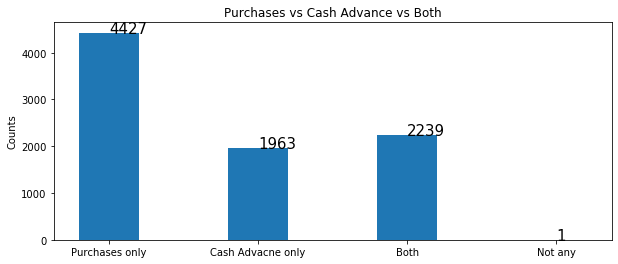

In [23]:
counts = {
    'Purchases only':((card_df_KPI['monthly_avg_purchase']!=0) & (card_df_KPI['monthly_cash_advance']==0)).sum(),
    'Cash Advance only':((card_df_KPI['monthly_cash_advance']!=0) & (card_df_KPI['monthly_avg_purchase']==0)).sum(),
    'Both':((card_df_KPI['monthly_avg_purchase']!=0) & (card_df_KPI['monthly_cash_advance']!=0)).sum(),
    'Not any':((card_df_KPI['monthly_avg_purchase']==0) & (card_df_KPI['monthly_cash_advance']==0)).sum()
}
labels = counts.keys()
values = counts.values()
fig = plt.figure(figsize=(10,4))
plt.bar(labels,values, width=0.4)
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.ylabel('Counts')
plt.title("Purchases vs Cash Advance vs Both")
plt.savefig('images/2.1.png')
plt.show()

### 2.2 Let's compare the amounts of purchases and cash advance of monthly usages

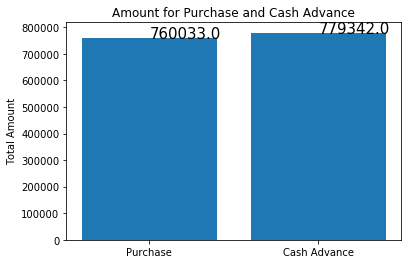

In [24]:
labels = ['Purchase','Cash Advance']
values = [card_df_KPI['monthly_avg_purchase'].sum(), card_df_KPI['monthly_cash_advance'].sum()]
plt.bar(labels, values)
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=15))
plt.title('Amount for Purchase and Cash Advance')
plt.ylabel("Total Amount")
plt.savefig('images/2.2.png')
plt.show()

### Now, Let's Dig into purchases

#### 2.3 We have two types of purchases, so let's find out how many uses oneoff, installments or both

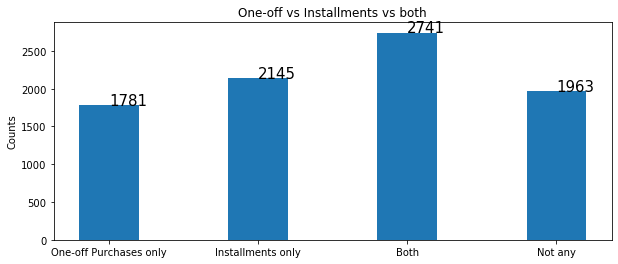

In [25]:
counts = {
    'One-off Purchases only':((card_df_KPI['monthly_oneoff_purchase']!=0) & (card_df_KPI['monthly_installment_purchase']==0)).sum(),
    'Installments only':((card_df_KPI['monthly_installment_purchase']!=0) & (card_df_KPI['monthly_oneoff_purchase']==0)).sum(),
    'Both':((card_df_KPI['monthly_oneoff_purchase']!=0) & (card_df_KPI['monthly_installment_purchase']!=0)).sum(),
    'Not any':((card_df_KPI['monthly_oneoff_purchase']==0) & (card_df_KPI['monthly_installment_purchase']==0)).sum()
}
labels = counts.keys()
values = counts.values()
fig = plt.figure(figsize=(10,4))
plt.bar(labels,values, width=0.4)
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.title("One-off vs Installments vs both")
plt.ylabel('Counts')
plt.savefig('images/2.3.png')
plt.show()

#### 2.4 Total amount for each type of Purchases

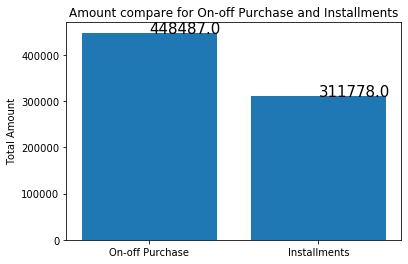

In [26]:
labels = ['On-off Purchase','Installments']
values = [card_df_KPI['monthly_oneoff_purchase'].sum(), card_df_KPI['monthly_installment_purchase'].sum()]
plt.bar(labels, values)
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=15))
plt.title('Amount compare for On-off Purchase and Installments')
plt.ylabel("Total Amount")
plt.savefig('images/2.4.png')
plt.show()

### 2.5 Average amount per purchase and per cash advance comparison

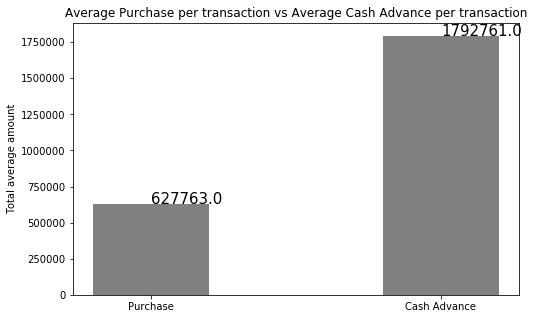

In [27]:
avg_purchase = card_df_KPI['average_amount_per_purchase'].sum()
avg_cash = card_df_KPI['average_amount_per_cash_advance'].sum()
labels = ['Purchase','Cash Advance']
values = [avg_purchase, avg_cash]
fig = plt.figure(figsize=(8,5))
plt.bar(labels, values, color='grey', width=0.4)
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=15))
plt.title('Average Purchase per transaction vs Average Cash Advance per transaction')
plt.ylabel("Total average amount")
plt.savefig('images/2.5.png')
plt.show()

### 2.6 People spending more than credit limit vs under credit limit but more than 50% vs less than 50%

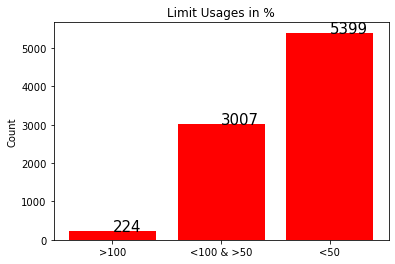

In [28]:
# card_df_KPI['b2c_lr']
more_limit = (card_df_KPI['b2c_lr']>100).sum()
less_limit = ((card_df_KPI['b2c_lr']>50) & (card_df_KPI['b2c_lr']<100)).sum()
less_50 = (card_df_KPI['b2c_lr']<50).sum()
labels = ['>100','<100 & >50','<50']
values = [more_limit, less_limit, less_50]
plt.bar(labels,values, color='red')
plt.title("Limit Usages in %")
plt.ylabel("Count")
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=15))
plt.savefig('images/2.6.png')
plt.show()

### 2.7 People who pay more than their minimum payments vs less than the minimum payment range

Here,
- <100 = Not paying enough
- '>100 = Paying more than required


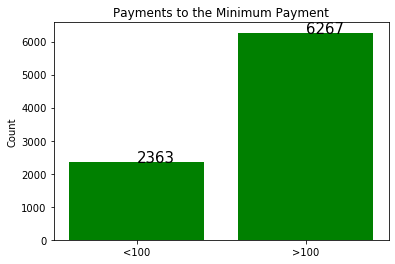

In [29]:
paying_less = (card_df_KPI['pay_to_minpay_ratio']<100).sum()
paying_more = (card_df_KPI['pay_to_minpay_ratio']>100).sum()
values = [paying_less,  paying_more]
labels = ['<100', '>100']
plt.bar(labels,values, color='green')
plt.title("Payments to the Minimum Payment")
plt.ylabel("Count")
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=15))
plt.savefig('images/2.7.png')
plt.show()

# 3. Clustering

Droping CUST_ID as there is no need

In [30]:
card_df.drop('CUST_ID', axis=1,inplace=True)

## Feature scaling

Normalizing the data

In [35]:
card_df_norm = MinMaxScaler().fit_transform(card_df)
pd.DataFrame(card_df_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.002148,0.818182,0.001945,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003978,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.000000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080892,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012263,0.008210,0.000000,1.0
3,0.042940,1.000000,0.000326,0.000393,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013373,0.003204,0.000000,1.0
4,0.095038,1.000000,0.027188,0.000000,0.059257,0.000000,0.666667,0.000000,0.583333,0.000000,0.00000,0.022346,0.058431,0.027602,0.031506,0.000000,1.0


## 3.1 Dimensionality Reduction - Factor Analysis

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis


In [36]:
chi_square_value,p_value=calculate_bartlett_sphericity(card_df_norm)
print(chi_square_value, p_value)

168105.4708831173 0.0


##### In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.


Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [37]:
kmo_all,kmo_model=calculate_kmo(card_df_norm)
kmo_model

C:\Users\91762\AppData\Local\Programs\Python\Python36\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.6410720120636468

###### Here kmo_model value is 0.64, so it is adequate.

### Choosing the Number of Factors

In [38]:
fa = FactorAnalyzer()
fa.set_params(n_factors=25, rotation=None)
fa.fit(card_df_norm)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([4.63228844e+00, 3.46601931e+00, 1.51462156e+00, 1.28778393e+00,
       1.06584601e+00, 9.70935522e-01, 8.36194743e-01, 7.16046060e-01,
       6.26370404e-01, 5.23593624e-01, 4.01811867e-01, 3.01428933e-01,
       2.42429872e-01, 1.97298034e-01, 1.71206664e-01, 4.61132978e-02,
       1.17202756e-05])

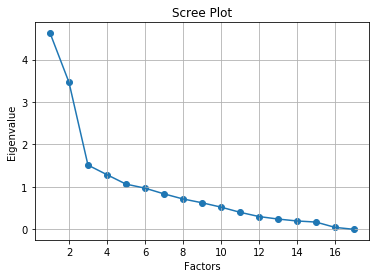

In [39]:
# Create scree plot using matplotlib
plt.scatter(range(1,card_df_norm.shape[1]+1),ev)
plt.plot(range(1,card_df_norm.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.savefig('images/Scree Plot.png')
plt.show()

The scree plot method draws a straight line for each factor and its eigenvalues. Number eigenvalues greater than one considered as the number of factors.

Here, you can see only for 5-factors eigenvalues are greater than one. It means we need to choose only 5 factors (or unobserved variables).

In [40]:
sk_fa = FactorAnalysis(n_components=5, random_state=0)
X_fa = sk_fa.fit_transform(card_df_norm)
# sk_fa.components_

In [41]:
X_fa.shape
# sk_fa.components_.shape

(8630, 5)

## Let's find out how mant clusters we can make

#### K-Means wcss score

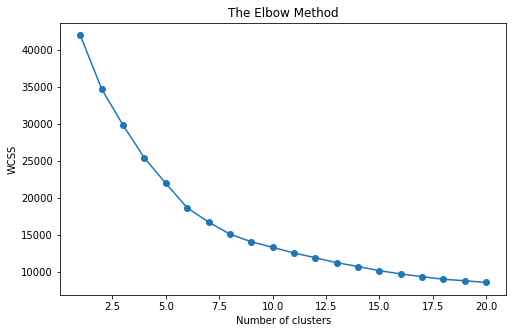

In [55]:
wcss = [] # Within cluster sum of squares
num = 21
for i in range(1,num):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_fa)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,num), wcss, marker="o")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('images/Wcss.png')
plt.show()

### Dendrogram

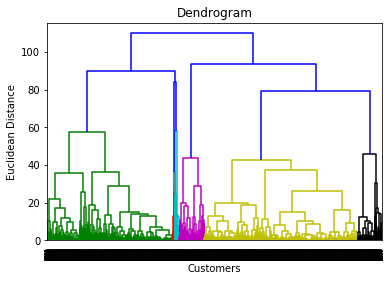

In [43]:
dendrogram = sch.dendrogram(sch.linkage(X_fa, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.savefig('images/Dendrogram.png')
plt.show()

#### Based on elbow method and dendrogram we can see that  7 clusters are required

In [68]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_kmeans = kmeans.fit_predict(X_fa)

In [69]:
pd.Series(y_kmeans).unique()

array([2, 0, 1, 4, 5, 6, 3], dtype=int64)

In [70]:
clustered_data = pd.concat([card_df_KPI['CUST_ID'],pd.DataFrame(X_fa), pd.DataFrame(y_kmeans)], axis=1)
clustered_data.head()

,CUST_ID,0,1,2,3,4,0
0,C10001,-0.420667,-0.129492,0.673971,-0.869714,-0.464466,2.0
1,C10002,-0.455693,-0.236857,1.155738,0.630645,0.025174,2.0
2,C10003,-0.067794,-0.514662,-1.567451,0.792246,-0.663785,0.0
3,NaN,-0.447577,-0.241453,0.874195,-0.533618,-0.688064,2.0
4,C10005,0.030644,1.232552,-0.076981,0.060876,-0.587285,0.0


In [71]:
card_df_clustered = pd.concat([card_df_KPI['CUST_ID'],card_df, pd.DataFrame(y_kmeans)], axis=1).dropna()
card_df_clustered.rename(columns={0:'Clusters'}, inplace=True)
card_df_clustered.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,2.0
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,2.0
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,0.0
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,0.0
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0.0,8.0,1800.0,1400.057770,2407.246035,0.000000,12.0,1.0
